# Лабораторная работа "Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей."

## Цель работы


## Задание
1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
1. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
1. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
1. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.
1. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
1. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.
1. Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
1. Постройте кривые обучения и валидации.

## Загрузка и первичный анализ данных
Используем данные [german_credit_data_with_risk](https://www.kaggle.com/kabure/german-credit-data-with-risk/downloads/german-credit-data-with-risk.zip/1)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_curve,confusion_matrix, roc_auc_score, accuracy_score, balanced_accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [0]:
data = pd.read_csv('/gdrive/My Drive/Colab Notebooks/ММО/lab4/data/german_credit_data.csv', sep=",")

In [0]:
# размер набора данных
data.shape

(1000, 11)

In [0]:
# типы колонок
data.dtypes

Unnamed: 0           int64
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [0]:
# проверим есть ли пропущенные значения
data.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [0]:
# Первые 5 строк датасета
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [0]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 1000


## Обработка пропусков в категориальных данных*italicized text*

In [0]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Saving accounts. Тип данных object. Количество пустых значений 183, 18.3%.
Колонка Checking account. Тип данных object. Количество пустых значений 394, 39.4%.


In [0]:
from sklearn.impute import SimpleImputer
# Импьютация наиболее частыми значениями
imp1 = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(data=imp1.fit_transform(data), columns=data.columns).astype(data.dtypes.to_dict())

In [0]:
# Первые 5 строк датасета
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,little,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,little,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [0]:
# проверим есть ли пропущенные значения
data.isnull().sum()

Unnamed: 0          0
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [0]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 1000


## Преобразование категориальных признаков в числовые

In [0]:
from sklearn.preprocessing import LabelEncoder
data = data.apply(LabelEncoder().fit_transform)

In [0]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,48,1,2,1,0,0,142,2,5,1
1,1,3,0,2,1,0,1,770,29,5,0
2,2,30,1,1,1,0,0,390,8,3,1
3,3,26,1,2,0,0,0,848,26,4,1
4,4,34,1,2,0,0,0,734,17,1,0


## Разделите выборки на обучающую и тестовую

In [0]:
X = data.drop('Risk',axis=1).values
y = data['Risk'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)
print('X_train: {}  y_train: {}'.format(X_train.shape, y_train.shape))
print('X_test: {}  y_test: {}'.format(X_test.shape, y_test.shape))

X_train: (700, 10)  y_train: (700,)
X_test: (300, 10)  y_test: (300,)


## Обучение модели ближайших соседей
Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.

In [0]:
# Setup arrays to store training and test accuracies
neighbors = np.arange(1,14)
len(neighbors)

13

### Обучение при различном количестве соседей

In [0]:
# Вернуть новый массив заданной формы и типа без инициализации записей.
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    # Настройка классификатора Knn с K соседями
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Обучить модель
    knn.fit(X_train, y_train)
    
    # Вычислить точность на тренировочном наборе
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Вычислить точность на тестовом наборе
    test_accuracy[i] = knn.score(X_test, y_test)

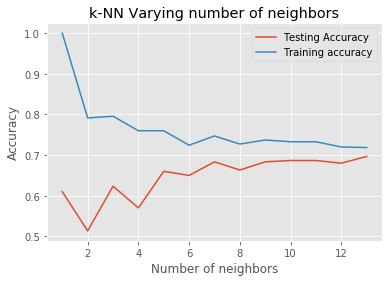

In [0]:
# Построить набор
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

### Изучение работы KNeighborsClassifier

In [0]:
# Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(n_neighbors=10)

In [0]:
#Fit the model
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [0]:
#Get accuracy. Note: In case of classification algorithms score method represents accuracy.
knn.score(X_test,y_test)

0.6866666666666666

In [0]:
#import classification_report
from sklearn.metrics import classification_report

y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.45      0.22      0.30        90
           1       0.73      0.89      0.80       210

    accuracy                           0.69       300
   macro avg       0.59      0.55      0.55       300
weighted avg       0.64      0.69      0.65       300



### Точность

In [0]:
cl1_1 = KNeighborsClassifier(n_neighbors=7)
cl1_1.fit(X_train, y_train)
target1_1 = cl1_1.predict(X_test)
accuracy_score(y_test, target1_1)

0.6833333333333333

### Матрица неточностей

In [0]:
y_pred = knn.predict(X_test)
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,20,70,90
1,24,186,210
All,44,256,300


### ROC-кривая
ROC-кривая (англ. receiver operating characteristic, рабочая характеристика приёмника) — график, позволяющий оценить качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущих признак, (англ. true positive rate, TPR, называемой чувствительностью алгоритма классификации) и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущих признак (англ. false positive rate, FPR, величина 1-FPR называется специфичностью алгоритма классификации) при варьировании порога решающего правила.

Также известна как кривая ошибок. Анализ классификаций с применением ROC-кривых называется ROC-анализом.

[0.6 0.8 0.6 0.6 0.3 0.7 0.6 0.6 0.7 0.9 0.8 0.9 0.6 0.7 0.5 0.5 0.8 0.7
 0.6 0.6 0.6 0.7 0.9 0.5 0.5 0.8 0.9 0.6 0.9 0.7 0.6 1.  0.5 0.5 1.  0.6
 0.6 0.5 0.8 0.9 0.7 0.9 0.7 0.8 0.8 0.6 0.9 0.7 0.8 0.7 0.8 0.5 0.9 0.6
 0.7 0.8 0.9 0.8 0.7 0.7 0.7 0.6 0.9 0.6 0.8 0.7 0.9 0.5 0.5 1.  0.8 0.7
 0.8 1.  0.5 0.8 0.6 0.4 0.9 0.4 0.9 0.8 0.6 0.6 0.8 0.7 0.7 0.7 0.8 0.7
 0.3 0.5 0.8 0.6 0.8 0.7 0.8 0.3 0.5 0.6 0.7 0.7 1.  0.9 0.5 0.7 0.9 0.6
 0.5 0.7 0.7 0.8 0.5 0.8 0.4 0.7 0.8 0.9 0.7 0.9 0.9 0.6 0.8 0.7 0.6 0.9
 0.8 0.8 0.7 0.8 0.6 0.8 0.7 0.7 0.8 0.8 0.7 0.8 0.7 0.7 0.6 0.6 0.6 0.8
 0.8 0.6 0.9 0.7 0.8 0.6 0.7 0.5 0.6 0.8 0.9 0.7 0.6 0.7 0.7 0.5 0.8 1.
 0.7 0.5 0.5 0.6 1.  0.7 0.9 0.6 0.7 0.8 0.7 0.7 0.8 0.7 0.5 0.6 0.5 0.8
 0.8 0.9 0.8 0.2 0.7 1.  0.7 0.8 0.7 0.7 0.7 0.4 0.8 0.9 0.8 0.9 0.8 0.8
 0.6 0.7 0.9 0.7 0.6 0.5 0.8 0.8 0.8 0.8 0.9 0.9 0.6 0.9 0.6 0.9 0.7 0.6
 0.8 0.6 0.8 0.7 0.9 0.6 0.7 0.9 0.8 0.5 0.5 0.7 0.5 0.6 0.7 0.8 0.6 0.8
 0.7 0.6 0.5 0.4 0.7 0.7 0.4 0.6 0.8 0.6 0.9 0.8 0.4

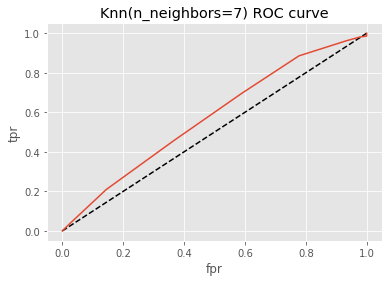

In [0]:
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=7) ROC curve')
plt.show()

## Кросс-валидация

In [0]:
param_grid = {'n_neighbors':np.arange(1,14)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
knn_cv.best_score_

0.6814285714285714

In [0]:
knn_cv.best_params_

{'n_neighbors': 13}

### K-fold
Данная стратегия работает в соответствии с определением кросс-валидации.
​
Каждой стратегии в scikit-learn ставится в соответствии специальный класс-итератор, который может быть указан в качестве параметра cv функций cross_val_score и cross_validate.

In [0]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=4), 
                         X, y, 
                         cv=KFold(n_splits=5))

# Значение метрики accuracy для 5 фолдов
scores

array([0.645, 0.495, 0.59 , 0.435, 0.58 ])

In [0]:
# Усредненное значение метрики accuracy для 5 фолдов
np.mean(scores)

0.549

In [0]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

scores = cross_validate(KNeighborsClassifier(n_neighbors=4), 
                        X, y, scoring=scoring, 
                        cv=KFold(n_splits=5), return_train_score=True)
scores

{'fit_time': array([0.00201154, 0.00129342, 0.00121665, 0.00121522, 0.0007863 ]),
 'score_time': array([0.02882528, 0.02052975, 0.01982617, 0.01997352, 0.01948166]),
 'test_f1': array([0.62987086, 0.51840635, 0.59259635, 0.44927048, 0.58807327]),
 'test_precision': array([0.61965909, 0.68385187, 0.59563909, 0.54384664, 0.59875751]),
 'test_recall': array([0.645, 0.495, 0.59 , 0.435, 0.58 ]),
 'train_f1': array([0.74393868, 0.74340909, 0.76341709, 0.75606276, 0.75093666]),
 'train_precision': array([0.7570328 , 0.75549846, 0.77102762, 0.76797146, 0.76221866]),
 'train_recall': array([0.7375 , 0.7375 , 0.75875, 0.75   , 0.745  ])}

### Leave One Out (LOO)
В тестовую выборку помещается единственный элемент (One Out). Количество фолдов в этом случае определяется автоматически и равняется количеству элементов.

Данный метод более ресурсоемкий чем KFold.

Существует эмпирическое правило, что вместо Leave One Out лучше использовать KFold на 5 или 10 фолдов.

In [0]:
loo = LeaveOneOut()
loo.get_n_splits(X)

for train_index, test_index in loo.split(X):
   y_train, y_test = y[train_index], y[test_index]

### Repeated K-Fold

In [0]:
scores2 = cross_val_score(KNeighborsClassifier(n_neighbors=4), 
                         X, y, 
                         cv=RepeatedKFold(n_splits=5, n_repeats=2))
scores2

array([0.575, 0.57 , 0.555, 0.59 , 0.53 , 0.6  , 0.585, 0.585, 0.615,
       0.575])

## Обучение с оптимальным K

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.6866666666666666

## Построение кривых обучения

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

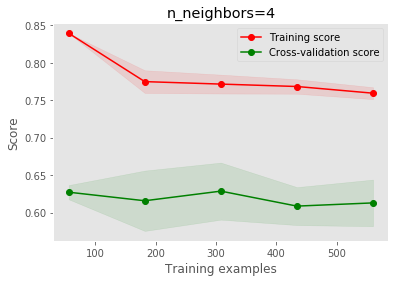

In [0]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=4), 'n_neighbors=4', 
                    X_train, y_train, cv=5)

## Построение кривой валидации

In [0]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

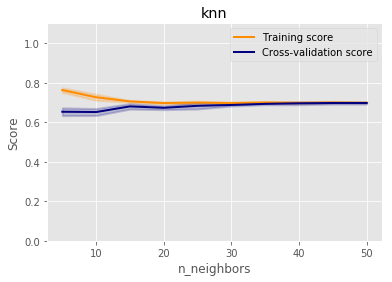

In [0]:
n_range = np.array(range(5,55,5))
plot_validation_curve(KNeighborsClassifier(n_neighbors=4), 'knn', 
                      X_train, y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=5, scoring="accuracy")